# Network Traffic Forecasting: Simulation Demo

This notebook validates the forecasting pipeline using synthetic data. 
It simulates multiple days of network traffic (sine waves with noise) to benchmark Prophet vs. DeepAR.

**Goal:** Train on historic cycles and predict the full next cycle (Next Day Forecast).

In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- SYSTEM IMPORTS ---
from config import Config
from data_processor import DatasetMeta
from models import ProphetAdapter, DeepARAdapter
from visualizer import plot_model_comparison, save_metrics

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Configuration Strategy
We override specific `Config` defaults to suit the synthetic data environment. 

**Crucial Change for DeepAR:** We simulate **5 cycles** (days). Deep Learning models require sufficient repetition to separate signal from noise.

In [7]:
# Initialize default config
cfg = Config()

# --- SIMULATION PARAMETERS ---
cfg.DT = 2.0               # 2-second granularity
CYCLE_LEN = 600            # Duration of one "day" pattern in seconds
NUM_CYCLES = 8             # INCREASED: More cycles = more learning signal for RNN

# --- MODEL HYPERPARAMETERS ---
cfg.EPOCHS = 60            # INCREASED: DeepAR needs longer training 
cfg.CONTEXT_LENGTH_MULTIPLIER = 2  # INCREASED: Give RNN 2 full cycles to learn

# --- DATA AUGMENTATION ---
cfg.AUGMENT_MULTIPLIER = 4  # INCREASED: 8 cycles → 32 effective cycles 
cfg.ADD_NOISE = True        # KEEP: Regularization
cfg.NOISE_LEVEL = 1         # REDUCED: Less noise lets DeepAR learn clean signal

# --- SPLIT STRATEGY ---
total_bins = int((CYCLE_LEN * NUM_CYCLES) / cfg.DT)
bins_per_cycle = int(CYCLE_LEN / cfg.DT)

cfg.MAX_TEST_SAMPLES = bins_per_cycle
cfg.TEST_SPLIT_RATIO = 1.0 / NUM_CYCLES

print(f"Simulation Config: {NUM_CYCLES} Cycles of {CYCLE_LEN}s.")
print(f"After Augmentation: {total_bins * cfg.AUGMENT_MULTIPLIER} points")
print(f"Test Horizon: {bins_per_cycle} points (1 Cycle)")

Simulation Config: 8 Cycles of 600s.
After Augmentation: 9600 points
Test Horizon: 300 points (1 Cycle)


## 2. Data Generation Factory
We create a robust generator that mimics daily network traffic volume (Morning rise, Noon peak, Night lull).

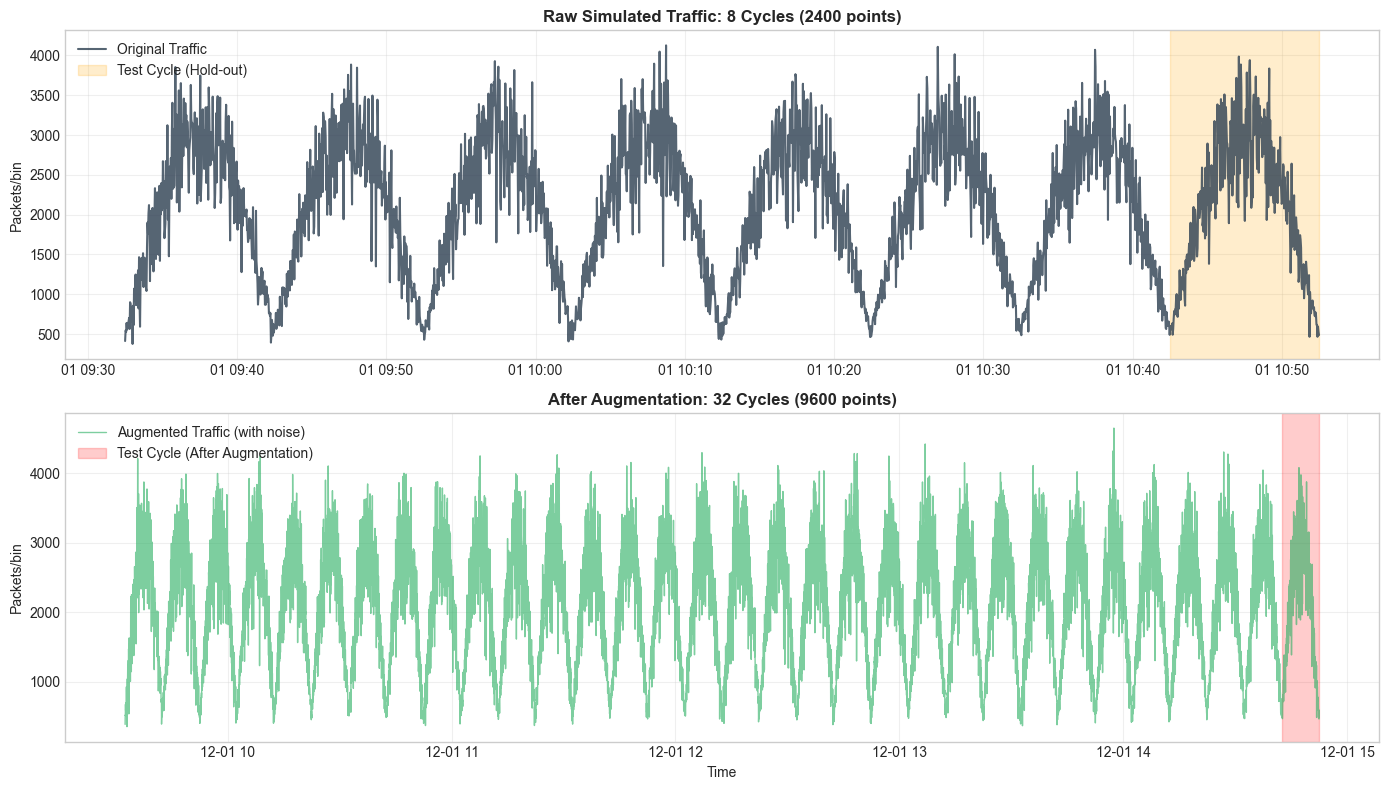


📊 Data Pipeline Summary:
  Raw Data:        2400 points (8 cycles)
  After Augment:   9600 points (32 cycles)
  Train/Test Split: 9300 / 300
  Augmentation Method: Cycle repetition + 1% noise injection


In [ ]:
def generate_traffic(config, cycle_len_sec, n_cycles):
    """
    Generates a sine-wave based traffic pattern with random noise.
    Returns: DataFrame, DatasetMeta
    """
    steps_per_cycle = int(cycle_len_sec / config.DT)
    total_steps = steps_per_cycle * n_cycles
    
    # 1. Time Axis
    t_vals = np.arange(total_steps) * config.DT
    start_date = datetime.now()
    timestamps = [start_date + timedelta(seconds=t) for t in t_vals]
    
    # 2. Signal Generation (Sine Wave 0 to Pi representing Day/Night)
    # We map one cycle to [0, pi] so sin(x) goes 0 -> 1 -> 0
    cycle_progress = (t_vals % cycle_len_sec) / cycle_len_sec * np.pi
    
    # Base Bandwidth + Peak Amplitude
    intensity = 2.0 + (10.0 * np.sin(cycle_progress))
    
    # 3. Convert to Packet Counts (Rough approximation)
    # packets = (Mbps * 1e6 * dt) / (8 bits/byte * ~1000 bytes/packet)
    base_packets = (intensity * 1e6 * config.DT) / 8000
    
    # 4. Add Heteroscedastic Noise (Noise increases with volume)
    noise_scale = base_packets * 0.15  # 15% variance
    noise = np.random.normal(0, noise_scale, size=len(base_packets))
    
    # Ensure non-negative
    final_packets = np.maximum(10, base_packets + noise)
    
    df = pd.DataFrame({'timestamp': timestamps, 'target': final_packets})
    
    # 5. Construct Metadata manually since we skipped the processor
    meta = DatasetMeta(
        period_seconds=cycle_len_sec,
        bins_per_cycle=steps_per_cycle,
        total_cycles=n_cycles,
        detection_method="Simulation (Manual)"
    )
    
    return df, meta

# Generate
df_sim, meta = generate_traffic(cfg, CYCLE_LEN, NUM_CYCLES)

# Visual Sanity Check - BEFORE augmentation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# --- Plot 1: Original Data ---
ax1.plot(df_sim['timestamp'], df_sim['target'], color='#2c3e50', alpha=0.8, linewidth=1.5, label='Original Traffic')
test_start_idx = len(df_sim) - cfg.MAX_TEST_SAMPLES
ax1.axvspan(df_sim['timestamp'].iloc[test_start_idx], df_sim['timestamp'].iloc[0], 
            color='orange', alpha=0.2, label='Test Cycle (Hold-out)')
ax1.set_title(f"Raw Simulated Traffic: {NUM_CYCLES} Cycles ({len(df_sim)} points)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Packets/bin")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: After Augmentation (Simulated) ---
# Simulate what augmentation does
augmented_cycles = []
for i in range(cfg.AUGMENT_MULTIPLIER):
    # Add noise to each repeated cycle
    noise_factor = np.random.normal(1.0, 0.05, size=len(df_sim))
    augmented_data = df_sim['target'].values * noise_factor
    augmented_data = np.maximum(10, augmented_data)  # Ensure non-negative
    augmented_cycles.append(augmented_data)

df_augmented = np.concatenate(augmented_cycles)
t_augmented = np.arange(len(df_augmented)) * cfg.DT
timestamps_aug = [df_sim['timestamp'].iloc[0] + timedelta(seconds=t) for t in t_augmented]

ax2.plot(timestamps_aug, df_augmented, color='#27ae60', alpha=0.6, linewidth=1.0, label='Augmented Traffic (with noise)')
# Highlight final test region after augmentation
test_start_aug = len(df_augmented) - cfg.MAX_TEST_SAMPLES
ax2.axvspan(timestamps_aug[test_start_aug], timestamps_aug[-1], 
            color='red', alpha=0.2, label='Test Cycle (After Augmentation)')
ax2.set_title(f"After Augmentation: {NUM_CYCLES * cfg.AUGMENT_MULTIPLIER} Cycles ({len(df_augmented)} points)", 
              fontsize=12, fontweight='bold')
ax2.set_ylabel("Packets/bin")
ax2.set_xlabel("Time")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Data Pipeline Summary:")
print(f"  Raw Data:        {len(df_sim)} points ({NUM_CYCLES} cycles)")
print(f"  After Augment:   {len(df_augmented)} points ({NUM_CYCLES * cfg.AUGMENT_MULTIPLIER} cycles)")
print(f"  Train/Test Split: {len(df_augmented) - cfg.MAX_TEST_SAMPLES} / {cfg.MAX_TEST_SAMPLES}")
print(f"  Augmentation Method: Cycle repetition + {cfg.NOISE_LEVEL}% noise injection")

## 3. Model Training & Evaluation
We run the models using the unified interface defined in `models.py`.

In [9]:
# Create augmented DataFrame for training
augmented_cycles = []
for i in range(cfg.AUGMENT_MULTIPLIER):
    noise_factor = np.random.normal(1.0, 0.05, size=len(df_sim))
    augmented_data = df_sim['target'].values * noise_factor
    augmented_data = np.maximum(10, augmented_data)
    augmented_cycles.append(augmented_data)

df_augmented_data = np.concatenate(augmented_cycles)
t_augmented = np.arange(len(df_augmented_data)) * cfg.DT
timestamps_aug = [df_sim['timestamp'].iloc[0] + timedelta(seconds=t) for t in t_augmented]

# Create DataFrame for training
df_train = pd.DataFrame({'timestamp': timestamps_aug, 'target': df_augmented_data})
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

# --- train on augmented data ---
results_store = {}
metrics_store = []

pipeline = [
    ("Prophet", ProphetAdapter(cfg, meta)),
    ("DeepAR", DeepARAdapter(cfg, meta))
]

print("--- Pipeline Execution ---")
for name, model in pipeline:
    print(f"\n> Processing {name}...")
    
    # 1. Prepare (Split)
    model.prepare_data(df_train)
    
    # 2. Train
    model.train()
    
    # 3. Predict
    forecast_df = model.predict()
    results_store[name] = forecast_df
    
    # 4. Metric Calculation
    mae = (forecast_df['actual'] - forecast_df['mean']).abs().mean()
    rmse = np.sqrt(((forecast_df['actual'] - forecast_df['mean']) ** 2).mean())
    print(f"  {name} MAE: {mae:.2f} | RMSE: {rmse:.2f}")

print("\nDone.")

--- Pipeline Execution ---

> Processing Prophet...


09:32:30 - cmdstanpy - INFO - Chain [1] start processing
09:32:31 - cmdstanpy - INFO - Chain [1] done processing
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  Prophet MAE: 291.03 | RMSE: 388.02

> Processing DeepAR...



  | Name  | Type        | Params | Mode  | In sizes                                                       | Out sizes    
-------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | train | [[1, 1], [1, 1], [1, 691, 7], [1, 691], [1, 691], [1, 300, 7]] | [1, 100, 300]
-------------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: |          | 50/? [00:13<00:00,  3.69it/s, v_num=3, train_loss=8.200]

Epoch 0, global step 50: 'train_loss' reached 8.19829 (best 8.19829), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:11<00:00,  4.29it/s, v_num=3, train_loss=7.260]

Epoch 1, global step 100: 'train_loss' reached 7.26363 (best 7.26363), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:11<00:00,  4.18it/s, v_num=3, train_loss=7.050]

Epoch 2, global step 150: 'train_loss' reached 7.04926 (best 7.04926), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:11<00:00,  4.19it/s, v_num=3, train_loss=7.040]

Epoch 3, global step 200: 'train_loss' reached 7.04314 (best 7.04314), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:11<00:00,  4.39it/s, v_num=3, train_loss=7.030]

Epoch 4, global step 250: 'train_loss' reached 7.02699 (best 7.02699), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:11<00:00,  4.23it/s, v_num=3, train_loss=7.020]

Epoch 5, global step 300: 'train_loss' reached 7.02100 (best 7.02100), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:11<00:00,  4.26it/s, v_num=3, train_loss=7.020]

Epoch 6, global step 350: 'train_loss' reached 7.02030 (best 7.02030), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:11<00:00,  4.41it/s, v_num=3, train_loss=6.990]

Epoch 7, global step 400: 'train_loss' reached 6.98653 (best 6.98653), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:12<00:00,  4.08it/s, v_num=3, train_loss=7.010]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:13<00:00,  3.64it/s, v_num=3, train_loss=7.010]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:12<00:00,  4.10it/s, v_num=3, train_loss=6.950]

Epoch 10, global step 550: 'train_loss' reached 6.95089 (best 6.95089), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:12<00:00,  4.12it/s, v_num=3, train_loss=6.970]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:11<00:00,  4.32it/s, v_num=3, train_loss=7.000]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:11<00:00,  4.33it/s, v_num=3, train_loss=6.960]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:11<00:00,  4.37it/s, v_num=3, train_loss=6.990]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:12<00:00,  4.15it/s, v_num=3, train_loss=6.970]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:12<00:00,  4.15it/s, v_num=3, train_loss=6.960]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:11<00:00,  4.17it/s, v_num=3, train_loss=6.980]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:11<00:00,  4.39it/s, v_num=3, train_loss=6.960]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:11<00:00,  4.21it/s, v_num=3, train_loss=6.960]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:11<00:00,  4.20it/s, v_num=3, train_loss=6.940]

Epoch 20, global step 1050: 'train_loss' reached 6.93519 (best 6.93519), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:11<00:00,  4.28it/s, v_num=3, train_loss=6.990]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:11<00:00,  4.37it/s, v_num=3, train_loss=6.980]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:12<00:00,  4.14it/s, v_num=3, train_loss=6.990]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:11<00:00,  4.20it/s, v_num=3, train_loss=6.960]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:27<00:00,  1.79it/s, v_num=3, train_loss=6.960]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:26<00:00,  1.91it/s, v_num=3, train_loss=6.950]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:21<00:00,  2.37it/s, v_num=3, train_loss=6.990]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:20<00:00,  2.39it/s, v_num=3, train_loss=6.950]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:22<00:00,  2.21it/s, v_num=3, train_loss=6.970]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:17<00:00,  2.79it/s, v_num=3, train_loss=6.970]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:18<00:00,  2.72it/s, v_num=3, train_loss=6.950]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:14<00:00,  3.41it/s, v_num=3, train_loss=6.940]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:15<00:00,  3.16it/s, v_num=3, train_loss=6.960]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:15<00:00,  3.32it/s, v_num=3, train_loss=6.950]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:14<00:00,  3.52it/s, v_num=3, train_loss=6.940]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:17<00:00,  2.93it/s, v_num=3, train_loss=6.950]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:15<00:00,  3.18it/s, v_num=3, train_loss=6.960]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:13<00:00,  3.79it/s, v_num=3, train_loss=6.930]

Epoch 38, global step 1950: 'train_loss' reached 6.92668 (best 6.92668), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:12<00:00,  4.10it/s, v_num=3, train_loss=6.940]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:12<00:00,  4.14it/s, v_num=3, train_loss=6.900]

Epoch 40, global step 2050: 'train_loss' reached 6.90277 (best 6.90277), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=40-step=2050.ckpt' as top 1


Epoch 41: |          | 50/? [00:12<00:00,  4.13it/s, v_num=3, train_loss=6.920]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:12<00:00,  4.05it/s, v_num=3, train_loss=6.930]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:15<00:00,  3.15it/s, v_num=3, train_loss=6.960]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:14<00:00,  3.39it/s, v_num=3, train_loss=6.920]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:15<00:00,  3.22it/s, v_num=3, train_loss=6.970]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:19<00:00,  2.51it/s, v_num=3, train_loss=6.930]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:12<00:00,  4.02it/s, v_num=3, train_loss=6.940]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:11<00:00,  4.22it/s, v_num=3, train_loss=6.930]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:12<00:00,  4.13it/s, v_num=3, train_loss=6.930]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |          | 50/? [00:14<00:00,  3.55it/s, v_num=3, train_loss=6.900]

Epoch 50, global step 2550: 'train_loss' reached 6.89609 (best 6.89609), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=50-step=2550.ckpt' as top 1


Epoch 51: |          | 50/? [00:12<00:00,  4.09it/s, v_num=3, train_loss=6.950]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [00:11<00:00,  4.17it/s, v_num=3, train_loss=6.920]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: |          | 50/? [00:10<00:00,  4.67it/s, v_num=3, train_loss=6.940]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [00:11<00:00,  4.35it/s, v_num=3, train_loss=6.930]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: |          | 50/? [03:57<00:00,  0.21it/s, v_num=3, train_loss=6.910]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: |          | 50/? [00:18<00:00,  2.70it/s, v_num=3, train_loss=6.930]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [00:13<00:00,  3.80it/s, v_num=3, train_loss=6.910]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [00:14<00:00,  3.46it/s, v_num=3, train_loss=6.900]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [00:14<00:00,  3.41it/s, v_num=3, train_loss=6.890]

Epoch 59, global step 3000: 'train_loss' reached 6.89171 (best 6.89171), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_3/checkpoints/epoch=59-step=3000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: |          | 50/? [00:14<00:00,  3.41it/s, v_num=3, train_loss=6.890]
  DeepAR MAE: 289.59 | RMSE: 390.21

Done.


## 4. Visualization
Comparing the actual ground truth against the model forecasts.

✓ Saved comparison plot: output/demo_days_results.png


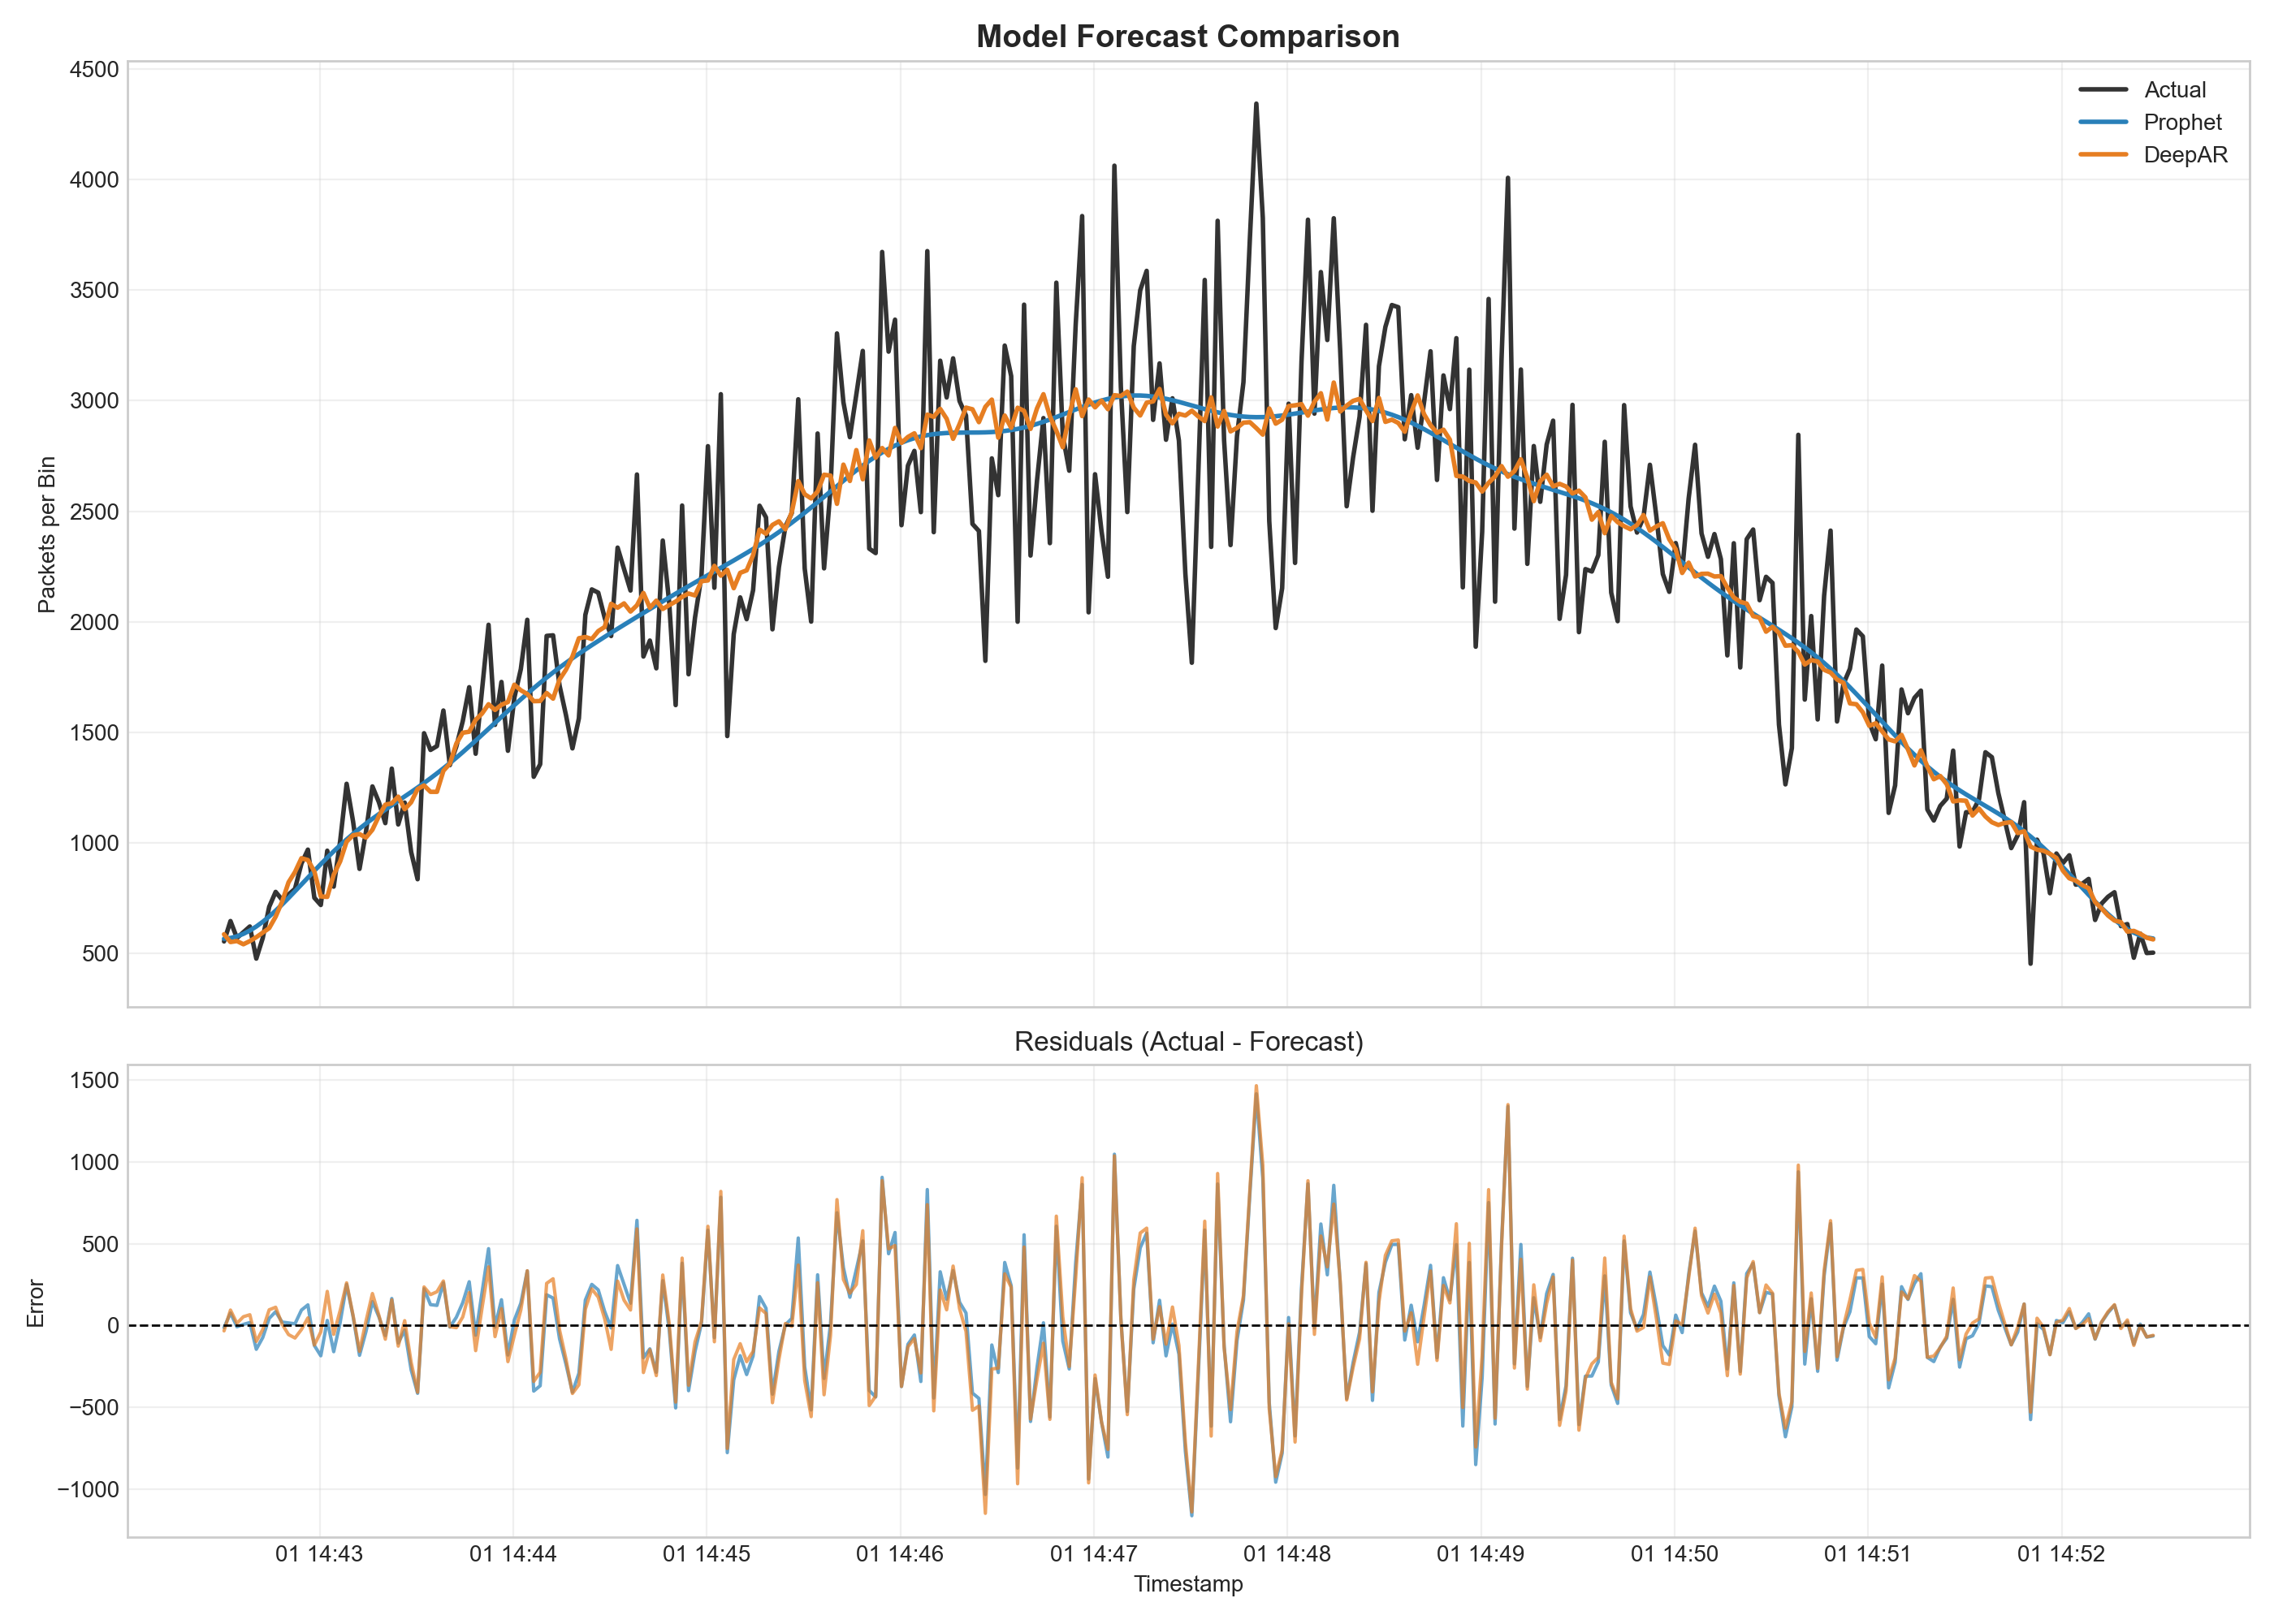

In [10]:
output_file = cfg.OUTPUT_DIR / "demo_days_results.png"
plot_model_comparison(results_store, output_file)

# Display in Notebook
from IPython.display import Image, display
display(Image(filename=output_file))